In [70]:
""" 
Introduction

Problem: Train a classifier that can classify between serif and sansserif font styles.

Approach: 

Font style classification: 1) They are character dependant. 
                              So any style classifier should be able to recognize character as well
                           2) Number of images given for each style is small - Use data augmentation techniques
                              I've used randomized resizing and translations to achieve this effect
                           3) Fonts are different - Classifier must be font invariant. I've not used any validation here
                              during training but I've a held out test set that I predict on after training.
                              

Strategy: 1) I've use MNIST CNN architecture to train on images.
          2) The classifier learns to classify into 52 classes (26 serif and 26 sansserif).
             This is to make sure the classifier can recognize the images.
             The results can easily be translated to binary classification.
          3) Keep certain fonts out for held out test set. 
             The results should be close to real-world performance.

Results: The classifier achieves 78% overall accurace for the multiclass classification.
         For the binary classification task, it achieves
         
                precision    recall  f1-score   support

  sansserif       0.88      0.91      0.89       272
      serif       0.81      0.75      0.78       142

avg / total       0.85      0.86      0.85       414

Future work:  Use larger CNN model
                Normalization of input images
                Weight decay regularization
                Use Keras
                Train longer


"""
        


" \nIntroduction\n\nProblem: Train a classifier that can classify between serif and sansserif font styles.\n\nApproach: \n\nFont style classification: 1) They are character dependant. \n                              So any style classifier should be able to recognize character as well\n                           2) Number of images given for each style is small - Use data augmentation techniques\n                              I've used randomized resizing and translations to achieve this effect\n                           3) Fonts are different - Classifier must be font invariant. I've not used any validation here\n                              during training but I've a held out test set that I predict on after training.\n                              \n\nStrategy: 1) I've use MNIST CNN architecture to train on images.\n          2) The classifier learns to classify into 52 classes (26 serif and 26 sansserif).\n             This is to make sure the classifier can recognize the images.

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Imports
import numpy as np
import tensorflow as tf
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import random

tf.logging.set_verbosity(tf.logging.INFO)


In [4]:
def read_folder(dir_name):

    values = []
    labels = []
    
    for img in os.listdir(dir_name):
        file = os.path.join(dir_name, img)
        if not file.endswith("png"):
            continue
        x = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        if x is None:
            print("Unable to read image", img)
            continue
        x_small = cv2.resize(x, (32,32), interpolation = cv2.INTER_AREA)
        values.append(x_small.flatten())
        labels.append("-".join([img.split(".")[0].split("-")[i].lower() for i in [0,2]]))
    
    data = np.array(values, dtype=np.float16)

    target = np.array(labels)
    return data, target


#print(data.shape)

In [56]:
# function for image distotion during training
def scale_and_translate(X, mode):
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        return X
    
    heights = [16, 24, 32]
    widths = [16, 24, 32]
    
    h = heights[random.randint(0,2)]
    w = widths[random.randint(0,2)]
    
    size = np.array([h, w])
    X = tf.image.resize_bilinear(X, size=size, align_corners=False)
    X = tf.image.resize_image_with_crop_or_pad(X, 32, 32)
    
    # Translate, left, right, up, down randomly upto half image being hidden randomly
    dx = random.randint(-8,8)
    dy = random.randint(-8,8)
    shift = np.array([dx,dy])
    X = tf.contrib.image.translate(X, shift)
    
    return X

# use mnist CNN model with some changes

def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
    
  input_layer = tf.reshape(features["x"], [-1, 32, 32, 1])

  # Apply image scaling and translation
  transformed_input = scale_and_translate(input_layer, tf.estimator.ModeKeys.TRAIN)
    

  # Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 32, 32, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = tf.layers.conv2d(
      inputs=transformed_input,
      filters=32,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)

  # Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 10, 10, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="valid",
      activation=tf.nn.relu)

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 10, 10, 64]
  # Output Tensor Shape: [batch_size, 5, 5, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 5, 5, 64]
  # Output Tensor Shape: [batch_size, 5 * 5 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 5 * 5 * 64])

  # Dense Layer
  # Densely connected layer with 1024 neurons
  # Input Tensor Shape: [batch_size, 5 * 5 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 52]
  logits = tf.layers.dense(inputs=dropout, units=52)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.MomentumOptimizer(learning_rate=0.001, momentum=0.9)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics (for EVAL mode)
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)


In [6]:

# Load training and eval data
# Two classes have been split approximately 3:4 with few fonts held out for testing

x_train1, y_train1 = read_folder('/home/bharath/logojoy/data/serif/train')
x_test1, y_test1 = read_folder('/home/bharath/logojoy/data/serif/test')
x_train2, y_train2 = read_folder('/home/bharath/logojoy/data/sansserif/train')
x_test2, y_test2 = read_folder('/home/bharath/logojoy/data/sansserif/test')

train_data = np.append(x_train1, x_train2, axis = 0)
eval_data = np.append(x_test1, x_test2, axis = 0)
train_labels = np.append(y_train1, y_train2, axis = 0)
eval_labels = np.append(y_test1, y_test2, axis = 0)

encoder = LabelEncoder()
encoder.fit(np.append(train_labels, eval_labels, axis = 0))
print(encoder.classes_)
train_labels = encoder.transform(train_labels)
eval_labels = encoder.transform(eval_labels)
    





['sansserif-a' 'sansserif-b' 'sansserif-c' 'sansserif-d' 'sansserif-e'
 'sansserif-f' 'sansserif-g' 'sansserif-h' 'sansserif-i' 'sansserif-j'
 'sansserif-k' 'sansserif-l' 'sansserif-m' 'sansserif-n' 'sansserif-o'
 'sansserif-p' 'sansserif-q' 'sansserif-r' 'sansserif-s' 'sansserif-t'
 'sansserif-u' 'sansserif-v' 'sansserif-w' 'sansserif-x' 'sansserif-y'
 'sansserif-z' 'serif-a' 'serif-b' 'serif-c' 'serif-d' 'serif-e' 'serif-f'
 'serif-g' 'serif-h' 'serif-i' 'serif-j' 'serif-k' 'serif-l' 'serif-m'
 'serif-n' 'serif-o' 'serif-p' 'serif-q' 'serif-r' 'serif-s' 'serif-t'
 'serif-u' 'serif-v' 'serif-w' 'serif-x' 'serif-y' 'serif-z']


In [9]:
# Tensorflow
# Create the Estimator
# Train!
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/home/bharath/logojoy/model/mnist_convnet_model3")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=25,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=10000,
    hooks=[logging_hook])

# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_tf_random_seed': None, '_session_config': None, '_num_ps_replicas': 0, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f40fb68a860>, '_service': None, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_task_id': 0, '_save_summary_steps': 100, '_model_dir': '/home/bharath/logojoy/model/mnist_convnet_model3', '_task_type': 'worker'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt-1
INFO:tensorflow:Saving checkpoints for 2 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:probabilities = [[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.6406    ...

INFO:tensorflow:step = 702, loss = 3.08 (569.951 sec)
INFO:tensorflow:Saving checkpoints for 743 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:probabilities = [[0.0015545  0.547      0.001882   ... 0.000625   0.000061   0.000182  ]
 [0.00378    0.0018425  0.0002804  ... 0.0002792  0.0000939  0.0001609 ]
 [0.002268   0.01624    0.002768   ... 0.000615   0.0004697  0.001774  ]
 ...
 [0.02536    0.01459    0.02182    ... 0.013145   0.01762    0.02008   ]
 [0.00004864 0.00007653 0.0000045  ... 0.00002027 0.00003475 0.001389  ]
 [0.008224   0.02385    0.00956    ... 0.001875   0.003672   0.00626   ]] (284.939 sec)
INFO:tensorflow:global_step/sec: 0.174971
INFO:tensorflow:probabilities = [[0.0009503 0.0001037 0.001072  ... 0.002125  0.001064  0.0009427]
 [0.0008473 0.0000378 0.0001981 ... 0.000596  0.0003042 0.000024 ]
 [0.02025   0.02103   0.02141   ... 0.01819   0.01692   0.01738  ]
 ...
 [0.01865   0.0477    0.00777   ... 0.02982   0.00784   0.004345 ]


INFO:tensorflow:step = 1402, loss = 0.944 (579.415 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000024 0.         0.         ... 0.         0.0000332  0.00001764]
 [0.01       0.0002304  0.002146   ... 0.0000014  0.0000007  0.0002133 ]
 ...
 [0.0002863  0.0001657  0.         ... 0.0000016  0.00000054 0.00000006]
 [0.         0.         0.         ... 0.0000017  0.         0.        ]
 [0.         0.000001   0.         ... 0.00000006 0.         0.        ]] (290.690 sec)
INFO:tensorflow:Saving checkpoints for 1462 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:global_step/sec: 0.170904
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.00000006 ... 0.         0.         0.        ]
 [0.000902   0.0006323  0.002232   ... 0.001042   0.0007     0.00005484]
 ...
 [0.         0.0000038  0.         ... 0.     

INFO:tensorflow:step = 2102, loss = 0.5073 (598.361 sec)
INFO:tensorflow:probabilities = [[0.         0.00001806 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.0000001  ... 0.0000001  0.         0.00000006]
 ...
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.0002083  0.00000024 0.954      ... 0.0000006  0.0000118  0.00005144]
 [0.000003   0.         0.0000002  ... 0.0000003  0.0000018  0.0000343 ]] (283.117 sec)
INFO:tensorflow:Saving checkpoints for 2182 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:global_step/sec: 0.176775
INFO:tensorflow:probabilities = [[0.00000066 0.         0.         ... 0.0003462  0.         0.        ]
 [0.02599    0.0001053  0.02249    ... 0.004017   0.002485   0.0002346 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.    

INFO:tensorflow:Saving checkpoints for 2851 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:probabilities = [[0.0003736  0.         0.0000002  ... 0.00000393 0.0000008  0.0000433 ]
 [0.0000005  0.         0.0000377  ... 0.         0.0000004  0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.0000019  0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (268.588 sec)
INFO:tensorflow:global_step/sec: 0.185919
INFO:tensorflow:probabilities = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (269.281 sec)
INFO:tensorflow:step = 2902, loss = 0.4812 (537.869 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.    

INFO:tensorflow:global_step/sec: 0.196592
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00000024 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (254.200 sec)
INFO:tensorflow:step = 3602, loss = 0.4116 (508.668 sec)
INFO:tensorflow:Saving checkpoints for 3638 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:probabilities = [[0.        0.        0.        ... 0.        0.0000001 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.0000104 0.        0.       ]
 ...
 [0.        0.0000002 0.        ... 0.        0.        0.     

INFO:tensorflow:step = 4302, loss = 0.3884 (508.510 sec)
INFO:tensorflow:Saving checkpoints for 4347 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000006 0.         0.         ... 0.0000005  0.         0.        ]
 ...
 [0.000006   0.0001015  0.         ... 0.         0.00000006 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (254.287 sec)
INFO:tensorflow:global_step/sec: 0.196398
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000006 0.         0.1683     ... 0.0000206  0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.    

INFO:tensorflow:global_step/sec: 0.19642
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.0001489  0.         0.         ... 0.000043   0.00000006 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (254.994 sec)
INFO:tensorflow:step = 5102, loss = 0.2228 (509.112 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.0002754  0.0000398  0.0000087  ... 0.00004303 0.0001246  0.0000357 ]
 [0.      

INFO:tensorflow:step = 5902, loss = 0.1115 (511.912 sec)
INFO:tensorflow:probabilities = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (256.420 sec)
INFO:tensorflow:global_step/sec: 0.195979
INFO:tensorflow:probabilities = [[0.0000002  0.00005484 0.00000364 ... 0.0000011  0.0000005  0.0000009 ]
 [0.         0.         0.9473     ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00925    0.0003302  0.0002156  ... 0.000325   0.0002332  0.002989  ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (253.838 sec)
INFO:tensorflow:step = 6002, loss = 0.524 (510.257 sec)
INFO:tensorflow:Saving checkpoints for 6007 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:probabilities = [[0. 0. 0. 

INFO:tensorflow:probabilities = [[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        1.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.02322   0.0004916 0.003521  ... 0.0000252 0.001433  0.001728 ]] (254.077 sec)
INFO:tensorflow:global_step/sec: 0.196485
INFO:tensorflow:probabilities = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (254.866 sec)
INFO:tensorflow:step = 6902, loss = 0.2147 (508.943 sec)
INFO:tensorflow:probabilities = [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (253.943 sec)
INFO:tensorflow:Saving checkpoints for 6953

INFO:tensorflow:step = 7702, loss = 0.10675 (507.925 sec)
INFO:tensorflow:probabilities = [[0.00009227 0.002882   0.002352   ... 0.0000573  0.0000348  0.0002283 ]
 [0.00001204 0.00005513 0.000263   ... 0.0000228  0.0001105  0.002151  ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00000036 0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (254.002 sec)
INFO:tensorflow:Saving checkpoints for 7785 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:global_step/sec: 0.196811
INFO:tensorflow:probabilities = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (254.100 sec)
INFO:tensorflow:step = 7802, loss = 0.1414 (508.101 sec)
INFO:tensorflow:probabilities = [[0. 0. 0

INFO:tensorflow:step = 8602, loss = 0.2195 (507.816 sec)
INFO:tensorflow:Saving checkpoints for 8614 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.9893     ... 0.         0.         0.        ]
 [0.00000006 0.         0.         ... 0.         0.         0.0000045 ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (254.588 sec)
INFO:tensorflow:global_step/sec: 0.19669
INFO:tensorflow:probabilities = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (253.827 sec)
INFO:tensorflow:step = 8702, loss = 0.0003128 (508.415 sec)
INFO:tensorflow:Saving checkpoints for 8

INFO:tensorflow:step = 9502, loss = 0.01022 (507.533 sec)
INFO:tensorflow:probabilities = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (253.688 sec)
INFO:tensorflow:Saving checkpoints for 9566 into /home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt.
INFO:tensorflow:global_step/sec: 0.197099
INFO:tensorflow:probabilities = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (253.672 sec)
INFO:tensorflow:step = 9602, loss = 1.4e-06 (507.359 sec)
INFO:tensorflow:probabilities = [[0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.   

In [ ]:
# Test data augmentation

# Things to try out:

# 1) (Down)Scaling, changing aspect ratio can imitate other fonts
# 2) Translation, hiding parts of letters can be good, network can learn to not rely on specific parts of image
# 3) Salt and pepper noise
# 4) Contrast transformations
# 5) Random patches
# 5) Line detections? (Not very NeuralNetwork'ic)

# Validation
# Keep certain fonts out for validation - better validation strategy

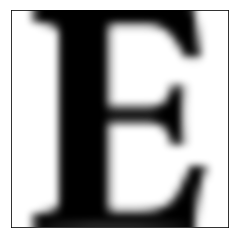

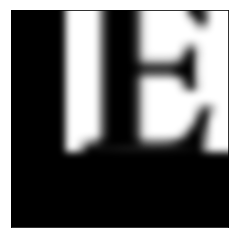

In [71]:
# Test Scaling and Translation

import random

def scale_and_translate2(X):
    
    heights = [16, 24, 32]
    widths = [16, 24, 32]
    
    h = heights[random.randint(0,2)]
    w = widths[random.randint(0,2)]
    
    size = np.array([h, w])
    X = tf.image.resize_bilinear(X, size=size, align_corners=False)
    X = tf.image.resize_image_with_crop_or_pad(X, 32, 32)
    
    # Translate, left, right, up, down randomly upto half image being hidden randomly
    dx = random.randint(-8,8)
    dy = random.randint(-8,8)
    shift = np.array([dx,dy])
    X = tf.contrib.image.translate(X, shift)
    
    return X

# test plot
def plot_image(img, title):
    plt.imshow(np.reshape(img, (32,32)).astype(int), cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title(title)
    plt.show()

plot_image(train_data[2], '')


x = tf.reshape(train_data[2].astype(int), [-1, 32, 32, 1])
x = scale_and_translate2(x)

sess = tf.InteractiveSession()
plot_image(tf.Session().run(x), '')

In [82]:
mnist_classifier2 = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/home/bharath/logojoy/model/mnist_convnet_model3")
with tf.Session() as sess:
    #saver = tf.train.import_meta_graph("/home/bharath/logojoy/model/mnist_convnet_model/model.ckpt-6578.meta")
    #saver.restore(sess, "/home/bharath/logojoy/model/mnist_convnet_model/model.ckpt-6578")
    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
    mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/home/bharath/logojoy/model/mnist_convnet_model3")
    eval_results = mnist_classifier2.predict(input_fn=eval_input_fn)#, 
                                #checkpoint_path="/home/bharath/logojoy/model/mnist_convnet_model3/model.ckpt-10001")
    eval_preds = []
    for x, each in enumerate(eval_results):
        eval_preds.append(each["classes"])
    
    eval_preds = encoder.inverse_transform(eval_preds)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_tf_random_seed': None, '_session_config': None, '_num_ps_replicas': 0, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f40e4390b00>, '_service': None, '_log_step_count_steps': 100, '_keep_checkpoint_every_n_hours': 10000, '_is_chief': True, '_task_id': 0, '_save_summary_steps': 100, '_model_dir': '/home/bharath/logojoy/model/mnist_convnet_model3', '_task_type': 'worker'}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_num_worker_replicas': 1, '_tf_random_seed': None, '_session_config': None, '_num_ps_replicas': 0, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f41464c96d8>, '_service': None, '

/home/bharath/anaconda3/envs/tf/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


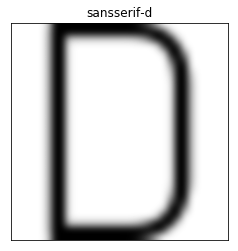

/home/bharath/anaconda3/envs/tf/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [88]:
# view predictions!!
from sklearn.metrics import classification_report

plot_image(eval_data[-6], eval_preds[-6])

binary_preds = [i.split('-')[0] for i in eval_preds]
binary_gt = [i.split('-')[0] for i in encoder.inverse_transform(eval_labels).tolist()]


In [85]:
print(classification_report(
          y_true=binary_gt, y_pred=binary_preds))

             precision    recall  f1-score   support

  sansserif       0.88      0.91      0.89       272
      serif       0.81      0.75      0.78       142

avg / total       0.85      0.86      0.85       414

